# Capstone: Budget & Environmentally Friendly Vehicle Recommender System  
**Author:** Sundus Yawar  
**Sprint:** 2  
**Student ID:** 583854  
**Institute:** BrainStation  
**Capstone Supervisor:** Amir Rahimizadeh

# Table of Content
[Overview](#Overview)
- [Data Dictionary](#Data-Dictionary)
- [What was Done in Previous Sprints](#What-was-Done-in-Previous-Sprints)
    - [Sprint 1](#Sprint-1)
    - [Sprint 2](#Sprint-2)
- [Focus for this Sprint](#Focus-for-this-Sprint)  
  
[Importing & Verifying the data](#Importing-&-Verifying-the-data)    

[Minimal Data Wrangling for this Sprint](#Minimal-Data-Wrangling-for-this-Sprint)    

[Scaling the Data and Performing Onehotencoding](#Scaling-the-Data-and-Performing-Onehotencoding)    

[Backward Feature Selection with K-Means](#Backward-Feature-Selection-with-K-Means)  
- [Some Functions for Modeling](#Some-Functions-for-Modeling)
- [Function for Dropping Feature 1 at a Time](#Function-for-Dropping-Feature-1-at-a-Time)
- [Modeling](#Modeling)
    - [All Features Included](#All-Features-Included)
    - [Drop Make](#Drop-Make)
    - [Drop Transmission Type](#Drop-Transmission-Type)
    - [Drop Fuel Type](#Drop-Fuel-Type)
    - [Drop Model_Year](#Drop-Model_Year)
- [Joining Model Stats DataFrames for Feature Selection](#Joining-Model-Stats-DataFrames-for-Feature-Selection)
    - [Final K-Means Model](#Final-K-Means-Model)

# Overview
The dataset I got for fuel consumption rating had features that can help determine whether a vehicle is green or not green, however, it doesn't contain labels for the vehicles whether they are green or not green. Since the data does not contain any labels, supervised machine learning algorithms can't be used. So, I'll be using clustering algorithms to determine the pattern and then analyze the clusters to label them as green or not green.
## Data Dictionary 

**Data Dictionary for transmission:**  
| Acronym | Definition                |
|:---------|:---------------------------|
| A       | Automatic                 |
| AM      | Automated manual          |
| AS      | Automatic with select shift |
| AV      | Continuously variable     |
| M       | Manual                    |
| 3 – 10  | Number of gears           |    
  
**Data Dictionary for fuel type:**   

| Code | Fuel Type           |
|:------|:---------------------|
| X    | Regular gasoline   |
| Z    | Premium gasoline   |
| D    | Diesel              |
| E    | Ethanol (E85)      |
| N    | Natural gas         |  
  
  
| Attribute         | Description                                                                             |
|:------------------|:----------------------------------------------------------------------------------------|
| Fuel Consumption  | City and highway fuel consumption ratings are shown in L/100 km and in mpg.           |
| CO2 Emissions     | Tailpipe emissions of carbon dioxide (g/km) for combined city and highway driving.     |
| CO2 Rating        | CO2 emissions rating on a scale from 1 (worst) to 10 (best).                             |
| Smog Rating       | Smog-forming pollutants emissions rating on a scale from 1 (worst) to 10 (best).        |  
  
## What was Done in Previous Sprints
### Sprint 1
- Data cleaning and wrangling
- EDA
- Some prices added from prices dataset to the fuel consumption rating dataset
### Sprint 2
- used clean data from sprint 1 ommitting the prices column as some were missing and didn't need to include prices for modeling anyways as explained in the overview of the Sprint 2 capstone
- Performed Feature Selection and Exngineering for columns with multicollinearity (dealt with numerical (VIF ANalysis) and categorical columns (chi2 test))
- Baseline Modeling, tuning, and evaluation based on only 4 features as a test
- Visualization of the clusters
- Post processing and basic analysis of the clusters
## Focus for this Sprint
- Use the feature selected data from Sprint 2 for further feature selection using backward selection as there are columns I am not sure about whether to include or not. These columns include, Make, Transmission_Type and Fuel_Type.
- After backward feature selection, use DBScan model as a final clustering algorithm.
- Analyze the clusters to label them as green or not green
- Add missing data for the prices
- Build the streamlit app
- Deploy it on Heroku

# Importing & Verifying the data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
fuel_cons_rating = pd.read_csv("Sprint2_featureSelection_result.csv")

In [3]:
fuel_cons_rating.shape

(6951, 9)

In [4]:
fuel_cons_rating.columns

Index(['Unnamed: 0', 'Model_Year', 'Make', 'Vehicle_Class', 'Transmission',
       'Fuel_Type', 'Fuel_Consumption-Comb(L/100 km)', 'CO2_Emissions(g/km)',
       'Smog_Rating'],
      dtype='object')

It added an unnecessary column called 'Unnamed: 0', so just removing that

In [5]:
fuel_cons_rating.drop("Unnamed: 0", axis=1, inplace=True)

In [6]:
#sanity check
fuel_cons_rating.head()

,Model_Year,Make,Vehicle_Class,Transmission,Fuel_Type,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating
0,2017,ACURA,COMPACT,AM8,Z,8.2,192,6
1,2017,ACURA,SUV - SMALL,AS9,Z,11.0,259,6
2,2017,ACURA,SUV - SMALL,AS9,Z,10.7,251,6
3,2017,ACURA,SUV - SMALL,AM7,Z,9.0,210,6
4,2017,ACURA,TWO-SEATER,AM9,Z,11.0,261,6


# Minimal Data Wrangling for this Sprint

In [7]:
fuel_cons_rating.select_dtypes(include=['int64']).columns.tolist()

['Model_Year', 'CO2_Emissions(g/km)', 'Smog_Rating']

I want Model_Year to be categorical rather than numeric because I dont want to apply standard scalar on year.

In [8]:
fuel_cons_rating['Model_Year'] = fuel_cons_rating['Model_Year'].astype('object')

In [9]:
# sanity check
fuel_cons_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6951 entries, 0 to 6950
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Model_Year                       6951 non-null   object 
 1   Make                             6951 non-null   object 
 2   Vehicle_Class                    6951 non-null   object 
 3   Transmission                     6951 non-null   object 
 4   Fuel_Type                        6951 non-null   object 
 5   Fuel_Consumption-Comb(L/100 km)  6951 non-null   float64
 6   CO2_Emissions(g/km)              6951 non-null   int64  
 7   Smog_Rating                      6951 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 434.6+ KB


# Scaling the Data and Performing Onehotencoding
I am scaling the data since fuel consumption, co2 emissions, smog rating have different value scales. And all categorical columns must be one hot encoded for the model to work.

In [10]:
from sklearn.preprocessing import StandardScaler

df_for_clustering = fuel_cons_rating.copy()

# Separating categorical and numerical columns 
categorical_columns = df_for_clustering.select_dtypes(include=['object']).columns
numerical_columns = ['Fuel_Consumption-Comb(L/100 km)', 'CO2_Emissions(g/km)', 'Smog_Rating']

# Instantiate
scaler = StandardScaler()
# Fit and Transform
df_for_clustering[numerical_columns] = scaler.fit_transform(df_for_clustering[numerical_columns])

df_for_clustering.head()

,Model_Year,Make,Vehicle_Class,Transmission,Fuel_Type,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating
0,2017,ACURA,COMPACT,AM8,Z,-0.990427,-1.026786,0.698072
1,2017,ACURA,SUV - SMALL,AS9,Z,0.010211,0.072781,0.698072
2,2017,ACURA,SUV - SMALL,AS9,Z,-0.097001,-0.058511,0.698072
3,2017,ACURA,SUV - SMALL,AM7,Z,-0.704531,-0.731380,0.698072
4,2017,ACURA,TWO-SEATER,AM9,Z,0.010211,0.105604,0.698072


In [11]:
categorical_columns

Index(['Model_Year', 'Make', 'Vehicle_Class', 'Transmission', 'Fuel_Type'], dtype='object')

In [12]:
df_for_clustering = pd.get_dummies(df_for_clustering, columns=categorical_columns, prefix=categorical_columns)
# sanity check
df_for_clustering.head()

C:\Users\Sundus Yawar\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating,Model_Year_2017,Model_Year_2018,Model_Year_2019,Model_Year_2020,Model_Year_2021,Model_Year_2022,Model_Year_2023,...,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Fuel_Type_D,Fuel_Type_E,Fuel_Type_X,Fuel_Type_Z
0,-0.990427,-1.026786,0.698072,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.010211,0.072781,0.698072,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.097001,-0.058511,0.698072,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.704531,-0.731380,0.698072,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.010211,0.105604,0.698072,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


**Sanity check**  
So, here I see that after applying one hot encoding, I have 95 columns. I just want to check unique value for each of my categorical columns to ensure that it adds up to 95 to ensure that all categorical columns got one hot encoded.

In [13]:
# Sanity Check
sum = fuel_cons_rating['Model_Year'].nunique() + fuel_cons_rating['Make'].nunique() + fuel_cons_rating['Vehicle_Class'].nunique()\
      + fuel_cons_rating['Transmission'].nunique() + fuel_cons_rating['Fuel_Type'].nunique()
sum

92

This makes sense, 92 is sum for all the categorical columns 1 hot encoded, and I have 3 numerical columns, 92+3=95. So, it did all the columns which is great.

# Backward Feature Selection with K-Means
## Some Functions for Modeling

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [15]:
def run_modeling(df):
    #n_samples=6951 should be >= n_clusters=10920
    ks = [2,15,22,26,30,52,92,104,105,184,210,420,840,900,1000,2000,3000,4000,5000,6000]

    sil_score = []
    inertia_score = []

    for k in ks:

        # Instantiate 
        kmeans = KMeans(n_clusters=k)

        # Fit
        y_labels = kmeans.fit_predict(df)


        # Append inertia and sil score
        inertia_score.append(kmeans.inertia_)
        sil_score.append(silhouette_score(df, y_labels))

        print(f'Running kmeans for k = {k}')
    return ks, kmeans, y_labels, inertia_score, sil_score

Later I'd like to join the dataframes based on n_clusters to see what gave better score for inertia and silhouette that's why putting it in data frame and adding prefix and setting n_clusters as index

In [16]:
def get_model_stats_df(ks, inertia_score, sil_score, prefix):
    df = pd.DataFrame({"n_clusters":ks,"inertia_score":inertia_score,"silhouette_score":sil_score})
    df.set_index("n_clusters",inplace=True)
    if prefix:
        df = df.add_prefix(prefix)
    return df

In [17]:
def visualizing_inertia_score(ks, inertia_score):
    plt.figure()

    plt.plot(ks, inertia_score, marker='o')

    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')

    plt.show()

In [18]:
def visualizing_silhouette_score(ks, sil_score):
    plt.figure()

    plt.plot(ks, sil_score, marker='o')

    plt.xlabel('Number of clusters')
    plt.ylabel('Sil score')

    plt.show()

## Function for Dropping Feature 1 at a Time

In [19]:
def drop_feature(df,prefix_to_drop):
    # Filter columns with the specified prefix
    columns_to_drop = df.filter(like=prefix_to_drop).columns

    # Drop the filtered columns
    return df.drop(columns=columns_to_drop)


## Modeling 
### All Features Included

In [20]:
ks, kmeans, y_labels, inertia_score, sil_score = run_modeling(df_for_clustering)

Running kmeans for k = 2
Running kmeans for k = 15
Running kmeans for k = 22
Running kmeans for k = 26
Running kmeans for k = 30
Running kmeans for k = 52
Running kmeans for k = 92
Running kmeans for k = 104
Running kmeans for k = 105
Running kmeans for k = 184
Running kmeans for k = 210
Running kmeans for k = 420
Running kmeans for k = 840
Running kmeans for k = 900
Running kmeans for k = 1000
Running kmeans for k = 2000
Running kmeans for k = 3000
Running kmeans for k = 4000
Running kmeans for k = 5000
Running kmeans for k = 6000


In [21]:
main_model_stats_df = get_model_stats_df(ks, inertia_score, sil_score,"").copy()
main_model_stats_df

,inertia_score,silhouette_score
n_clusters,,
2,39233.279591,0.179586
15,25995.715406,0.096932
22,23944.976750,0.099568
26,23129.218128,0.107433
30,22291.858599,0.108134
52,19652.739800,0.121304
92,16856.084821,0.134721
104,16327.400013,0.138754
105,16269.813524,0.142657


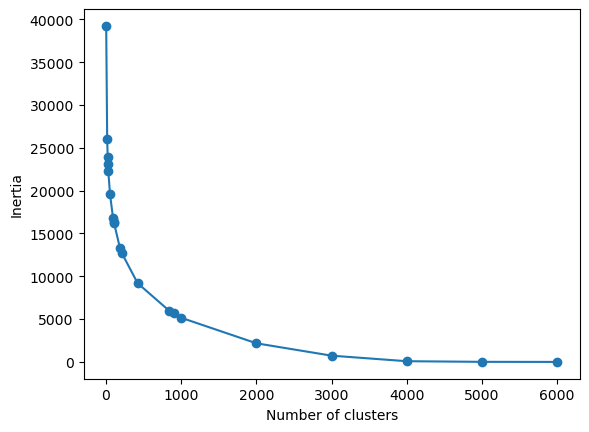

In [22]:
visualizing_inertia_score(ks, inertia_score)

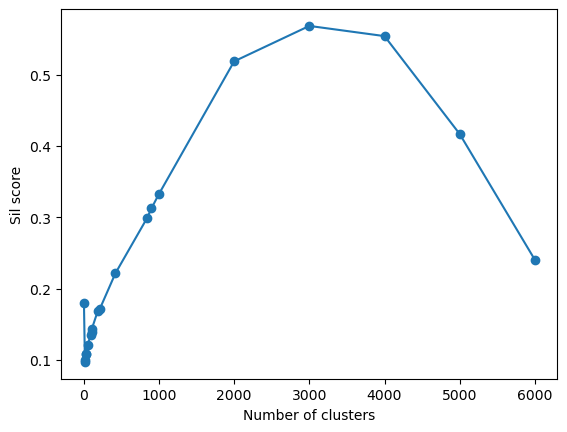

In [23]:
visualizing_silhouette_score(ks, sil_score)

Given the elbow of the inertia score and the peak of the silhouette score, I'd say I'll need 3,000 clusters. 3,000 clusters may make interpretability harder and may make the cluster analysis harder too. So, using backward feature selection, I'll try to determine if the number of clusters can be brought down.

### Drop Make

In [24]:
# Call the function
prefix_to_drop = "Make"
df_for_clustering_makeDropped = drop_feature(df_for_clustering,prefix_to_drop).copy()

**Sanity Check:** see if it dropped all one hot encoded columns for Make (Make had 40 unique values)  
- 95-40 = 55

In [25]:
df_for_clustering_makeDropped.shape

(6951, 55)

In [26]:
ks, kmeans, y_labels, inertia_score, sil_score = run_modeling(df_for_clustering_makeDropped)

Running kmeans for k = 2
Running kmeans for k = 15
Running kmeans for k = 22
Running kmeans for k = 26
Running kmeans for k = 30
Running kmeans for k = 52
Running kmeans for k = 92
Running kmeans for k = 104
Running kmeans for k = 105
Running kmeans for k = 184
Running kmeans for k = 210
Running kmeans for k = 420
Running kmeans for k = 840
Running kmeans for k = 900
Running kmeans for k = 1000
Running kmeans for k = 2000
Running kmeans for k = 3000
Running kmeans for k = 4000
Running kmeans for k = 5000


C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (5897) found smaller than n_clusters (6000). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Running kmeans for k = 6000


In [27]:
make_dropped_model_stats = get_model_stats_df(ks, inertia_score, sil_score,"makeDropped_").copy()
make_dropped_model_stats

,makeDropped_inertia_score,makeDropped_silhouette_score
n_clusters,,
2,3.264975e+04,0.204115
15,1.993582e+04,0.102986
22,1.842344e+04,0.106381
26,1.762115e+04,0.109864
30,1.696910e+04,0.115086
52,1.481155e+04,0.127704
92,1.250385e+04,0.144421
104,1.206405e+04,0.150495
105,1.200170e+04,0.152369


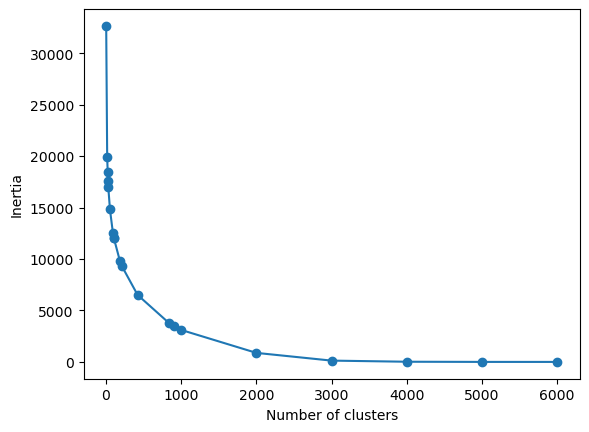

In [28]:
visualizing_inertia_score(ks, inertia_score)

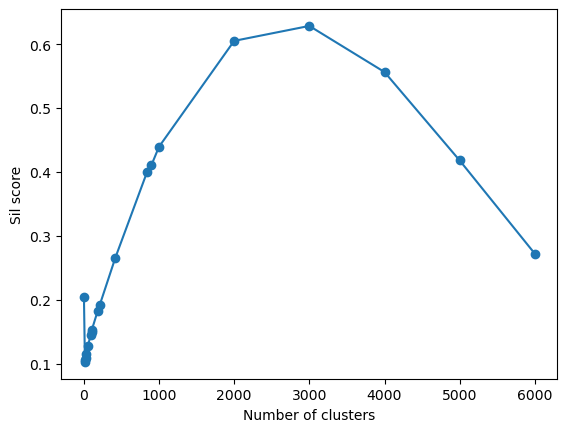

In [29]:
visualizing_silhouette_score(ks, sil_score)

### Drop Transmission Type

In [30]:
# Call the function
prefix_to_drop = "Transmission"
df_for_clustering_transDrop = drop_feature(df_for_clustering_makeDropped,prefix_to_drop).copy()

Sanity Check: see if it dropped all one hot encoded columns for Transmission (Transmission had 26 unique values)  
- 95-40-26 = 29

In [31]:
df_for_clustering_transDrop.shape

(6951, 29)

In [32]:
ks, kmeans, y_labels, inertia_score, sil_score = run_modeling(df_for_clustering_transDrop)

Running kmeans for k = 2
Running kmeans for k = 15
Running kmeans for k = 22
Running kmeans for k = 26
Running kmeans for k = 30
Running kmeans for k = 52
Running kmeans for k = 92
Running kmeans for k = 104
Running kmeans for k = 105
Running kmeans for k = 184
Running kmeans for k = 210
Running kmeans for k = 420
Running kmeans for k = 840
Running kmeans for k = 900
Running kmeans for k = 1000
Running kmeans for k = 2000
Running kmeans for k = 3000
Running kmeans for k = 4000
Running kmeans for k = 5000


C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (5659) found smaller than n_clusters (6000). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Running kmeans for k = 6000


In [33]:
transmission_dropped_model_stats = get_model_stats_df(ks, inertia_score, sil_score,"transDropped_").copy()
transmission_dropped_model_stats

,transDropped_inertia_score,transDropped_silhouette_score
n_clusters,,
2,2.642114e+04,0.234965
15,1.440162e+04,0.130617
22,1.283851e+04,0.144941
26,1.216764e+04,0.146296
30,1.165882e+04,0.151641
52,9.589026e+03,0.179539
92,7.645160e+03,0.213960
104,7.256795e+03,0.227746
105,7.203054e+03,0.226778


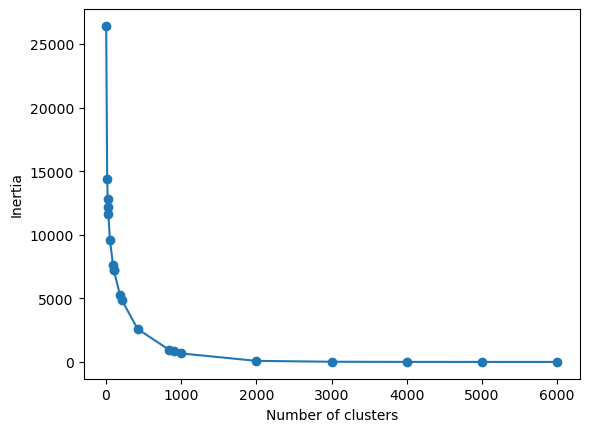

In [34]:
visualizing_inertia_score(ks, inertia_score)

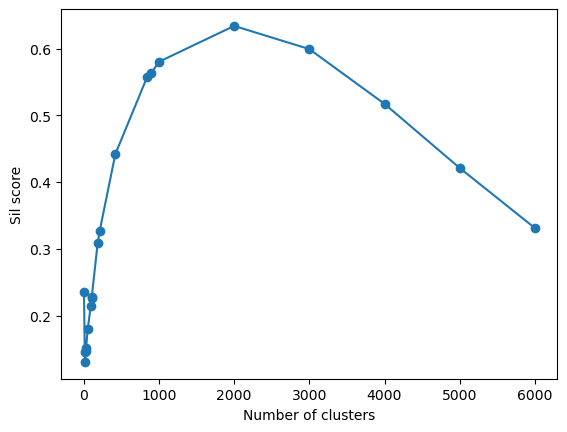

In [35]:
visualizing_silhouette_score(ks, sil_score)

### Drop Fuel Type

In [36]:
# Call the function
prefix_to_drop = "Fuel_Type"
df_for_clustering_fuelDrop = drop_feature(df_for_clustering_transDrop,prefix_to_drop).copy()

Sanity Check: see if it dropped all one hot encoded columns for Fuel_Type (Fuel_Type had 4 unique values)  
- 95-40-26-4 = 25

In [37]:
df_for_clustering_fuelDrop.shape

(6951, 25)

In [38]:
ks, kmeans, y_labels, inertia_score, sil_score = run_modeling(df_for_clustering_fuelDrop)

Running kmeans for k = 2
Running kmeans for k = 15
Running kmeans for k = 22
Running kmeans for k = 26
Running kmeans for k = 30
Running kmeans for k = 52
Running kmeans for k = 92
Running kmeans for k = 104
Running kmeans for k = 105
Running kmeans for k = 184
Running kmeans for k = 210
Running kmeans for k = 420
Running kmeans for k = 840
Running kmeans for k = 900
Running kmeans for k = 1000
Running kmeans for k = 2000
Running kmeans for k = 3000
Running kmeans for k = 4000
Running kmeans for k = 5000


C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (5550) found smaller than n_clusters (6000). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Running kmeans for k = 6000


In [39]:
fuelType_dropped_model_stats = get_model_stats_df(ks, inertia_score, sil_score,"fuelTypeDropped_").copy()
fuelType_dropped_model_stats

,fuelTypeDropped_inertia_score,fuelTypeDropped_silhouette_score
n_clusters,,
2,2.281197e+04,0.253943
15,1.250316e+04,0.131795
22,1.092724e+04,0.158938
26,1.032673e+04,0.159610
30,9.852660e+03,0.157176
52,7.986288e+03,0.192629
92,6.199626e+03,0.253270
104,5.841465e+03,0.266810
105,5.798389e+03,0.265478


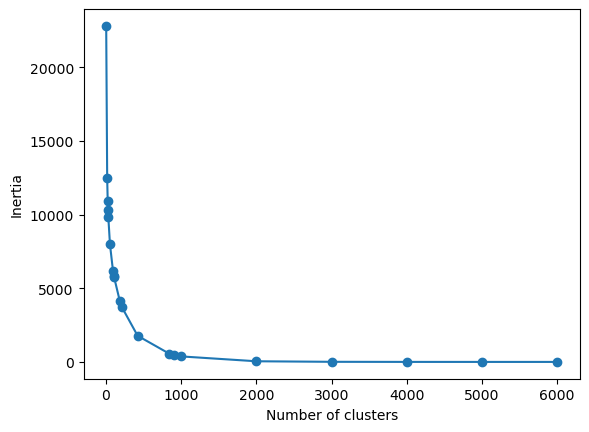

In [40]:
visualizing_inertia_score(ks, inertia_score)

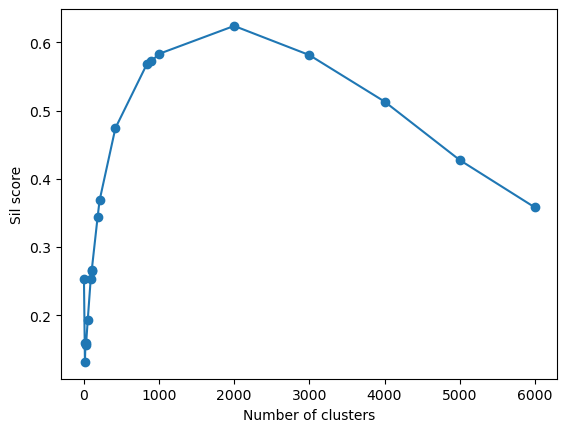

In [41]:
visualizing_silhouette_score(ks, sil_score)

### Drop Model_Year

In [42]:
# Call the function
prefix_to_drop = "Model_Year"
df_for_clustering_modYearDrop = drop_feature(df_for_clustering_fuelDrop,prefix_to_drop).copy()

Sanity Check: see if it dropped all one hot encoded columns for Model_Year (Model_Year had 7 unique values)  
- 95-40-26-4-7 = 18

In [43]:
df_for_clustering_modYearDrop.shape

(6951, 18)

In [44]:
ks, kmeans, y_labels, inertia_score, sil_score = run_modeling(df_for_clustering_modYearDrop)

Running kmeans for k = 2
Running kmeans for k = 15
Running kmeans for k = 22
Running kmeans for k = 26
Running kmeans for k = 30
Running kmeans for k = 52
Running kmeans for k = 92
Running kmeans for k = 104
Running kmeans for k = 105
Running kmeans for k = 184
Running kmeans for k = 210
Running kmeans for k = 420
Running kmeans for k = 840
Running kmeans for k = 900
Running kmeans for k = 1000
Running kmeans for k = 2000
Running kmeans for k = 3000


C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3499) found smaller than n_clusters (4000). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Running kmeans for k = 4000


C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3499) found smaller than n_clusters (5000). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Running kmeans for k = 5000


C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3499) found smaller than n_clusters (6000). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Running kmeans for k = 6000


In [45]:
modYear_dropped_model_stats = get_model_stats_df(ks, inertia_score, sil_score,"modYear_").copy()
modYear_dropped_model_stats

,modYear_inertia_score,modYear_silhouette_score
n_clusters,,
2,1.687542e+04,0.311707
15,6.792210e+03,0.242399
22,5.565537e+03,0.270127
26,5.015116e+03,0.287651
30,4.533314e+03,0.323765
52,3.013339e+03,0.389601
92,1.654014e+03,0.457089
104,1.441200e+03,0.477809
105,1.426842e+03,0.473972


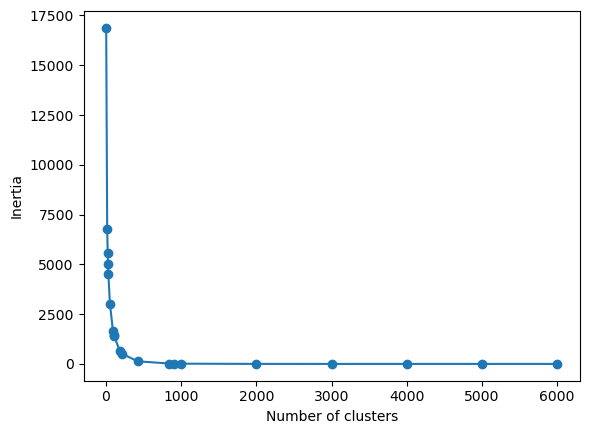

In [46]:
visualizing_inertia_score(ks, inertia_score)

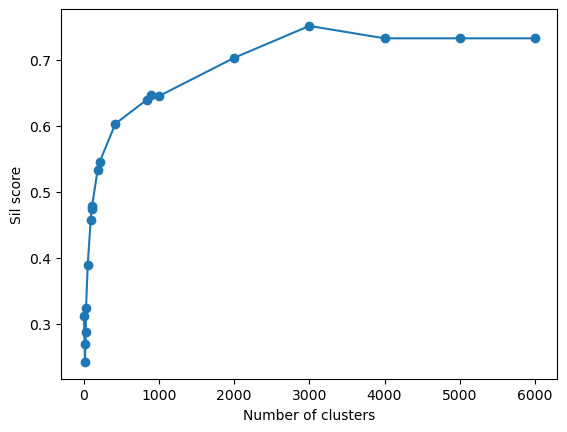

In [47]:
visualizing_silhouette_score(ks, sil_score)

In [53]:
df_for_clustering[df_for_clustering.duplicated()]

,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating,Model_Year_2017,Model_Year_2018,Model_Year_2019,Model_Year_2020,Model_Year_2021,Model_Year_2022,Model_Year_2023,...,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Fuel_Type_D,Fuel_Type_E,Fuel_Type_X,Fuel_Type_Z
10,-0.918953,-0.944729,0.139051,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
31,-0.347160,-0.271860,0.698072,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
42,1.118060,1.237993,0.139051,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
83,-0.668794,-0.682146,1.816113,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
84,-0.668794,-0.682146,1.816113,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6834,0.224633,0.335364,0.139051,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6851,2.011487,2.206268,-0.978989,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6853,2.047224,2.189857,-0.978989,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6854,2.047224,2.189857,-0.978989,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


### Investigating the Duplicates Observed During Clustering Warning

In [59]:
filter__ = fuel_cons_rating[fuel_cons_rating.duplicated(keep=False)]
filter__ = filter__.sort_values(by=['Model_Year','Make','Vehicle_Class'])
filter__

,Model_Year,Make,Vehicle_Class,Transmission,Fuel_Type,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating
9,2017,ALFA ROMEO,TWO-SEATER,AM6,Z,8.4,197,5
10,2017,ALFA ROMEO,TWO-SEATER,AM6,Z,8.4,197,5
30,2017,AUDI,MID-SIZE,AS8,Z,10.0,238,6
31,2017,AUDI,MID-SIZE,AS8,Z,10.0,238,6
41,2017,AUDI,TWO-SEATER,AM7,Z,14.1,330,5
...,...,...,...,...,...,...,...,...
6854,2023,ROLLS-ROYCE,FULL-SIZE,AS8,Z,16.7,388,3
6855,2023,ROLLS-ROYCE,FULL-SIZE,AS8,Z,17.0,397,3
6856,2023,ROLLS-ROYCE,FULL-SIZE,AS8,Z,17.0,397,3
6850,2023,ROLLS-ROYCE,STATION WAGON - MID-SIZE,AS8,Z,16.6,389,3


In [62]:
original_file = pd.read_csv("fuel_cons_rating_concatenated.csv")
original_file[original_file.duplicated()]

,Unnamed: 0,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),Fuel_Consumption-Comb(mpg),CO2_Emissions(g/km),CO2_Rating,Smog_Rating


As you can see the original data doesnt have any duplicates.The we observe here are due to dropping certain columns that make them appear same. So, I won't be removing any "duplicated" rows that resulted from backward feature selection. Because I want the labels from the model to concatenate to the dataframe.

## Joining Model Stats DataFrames for Feature Selection

In [48]:
stats_joined_df = main_model_stats_df.join([make_dropped_model_stats, transmission_dropped_model_stats, fuelType_dropped_model_stats,modYear_dropped_model_stats], how='inner')
stats_joined_df

,inertia_score,silhouette_score,makeDropped_inertia_score,makeDropped_silhouette_score,transDropped_inertia_score,transDropped_silhouette_score,fuelTypeDropped_inertia_score,fuelTypeDropped_silhouette_score,modYear_inertia_score,modYear_silhouette_score
n_clusters,,,,,,,,,,
2,39233.279591,0.179586,3.264975e+04,0.204115,2.642114e+04,0.234965,2.281197e+04,0.253943,1.687542e+04,0.311707
15,25995.715406,0.096932,1.993582e+04,0.102986,1.440162e+04,0.130617,1.250316e+04,0.131795,6.792210e+03,0.242399
22,23944.976750,0.099568,1.842344e+04,0.106381,1.283851e+04,0.144941,1.092724e+04,0.158938,5.565537e+03,0.270127
26,23129.218128,0.107433,1.762115e+04,0.109864,1.216764e+04,0.146296,1.032673e+04,0.159610,5.015116e+03,0.287651
30,22291.858599,0.108134,1.696910e+04,0.115086,1.165882e+04,0.151641,9.852660e+03,0.157176,4.533314e+03,0.323765
52,19652.739800,0.121304,1.481155e+04,0.127704,9.589026e+03,0.179539,7.986288e+03,0.192629,3.013339e+03,0.389601
92,16856.084821,0.134721,1.250385e+04,0.144421,7.645160e+03,0.213960,6.199626e+03,0.253270,1.654014e+03,0.457089
104,16327.400013,0.138754,1.206405e+04,0.150495,7.256795e+03,0.227746,5.841465e+03,0.266810,1.441200e+03,0.477809
105,16269.813524,0.142657,1.200170e+04,0.152369,7.203054e+03,0.226778,5.798389e+03,0.265478,1.426842e+03,0.473972


In the main dataframe, the elbow point in inertia score is not as prominent, so looking at the silhouette score, it seems having 3,000 clusters is the best solution here(inertia score = 730.9 and silhouette score = 0.57). However, it is not practical nor meaningful for the purpose of my project.  
I observe that as the features drop inertia and silhouette scores improve for smaller number of clusters. In the last one, where 4 columns have been dropped leaving only Vehicle_Class, Fuel_Consumption, CO2_Emissions, and Smog_Rating columns, I have much better score for inertia and silhouette score at 420 clusters which is a lot more practical and may serve well. Inertia score at this point is 130 and silhouette is 0.6 which is way better than main dataframe used for clustering.  
**It seems that my experiment in Sprint 2 with just these columns was the right choice** Moving forward with DBScan, I'd like to use these features.

### Baseline DBScan Model
DBScan has 2 very important hyperparameters:
- eps
    - radius of the cluster in other words farthest distance to a data point from the center
- min_samples
    - min number of data points to be considered a cluster  
  
I was researching how to best come up with min_samples and eps values. I found that we can start with ln(n_data_points) for min_samples. Given that the original data frame has 6,951 rows, I'll try ln(6951) = 8.845, so I'll try 9 as min_samples for the baseline, and later try values around this number for fine tuning the model. As for eps value, I read that it is better to do K-nearest_neighbour analysis, so I'll do that first. https://askdatascience.com/646/dbscan-algorithm-how-should-choose-optimal-minimum-points  
I looked into it further to determin what value to choose for the n-neighbours and found that n = 2*(number of columns) in the dataset. Now what I am not sure about is whether this N in 2xN is for columns before or after feature selection. So, I'll experiment with both. https://caveofpython.com/machine-learning/nearest-neighbours/  


In [65]:
df_for_clustering_modYearDrop.columns.to_list()

['Fuel_Consumption-Comb(L/100 km)',
 'CO2_Emissions(g/km)',
 'Smog_Rating',
 'Vehicle_Class_COMPACT',
 'Vehicle_Class_FULL-SIZE',
 'Vehicle_Class_MID-SIZE',
 'Vehicle_Class_MINICOMPACT',
 'Vehicle_Class_MINIVAN',
 'Vehicle_Class_PICKUP TRUCK - SMALL',
 'Vehicle_Class_PICKUP TRUCK - STANDARD',
 'Vehicle_Class_SPECIAL PURPOSE VEHICLE',
 'Vehicle_Class_STATION WAGON - MID-SIZE',
 'Vehicle_Class_STATION WAGON - SMALL',
 'Vehicle_Class_SUBCOMPACT',
 'Vehicle_Class_SUV - SMALL',
 'Vehicle_Class_SUV - STANDARD',
 'Vehicle_Class_TWO-SEATER',
 'Vehicle_Class_VAN - PASSENGER']

In [64]:
len(df_for_clustering_modYearDrop.columns)

18

2x18 = 36, so I'll need 36 n_neighbours 

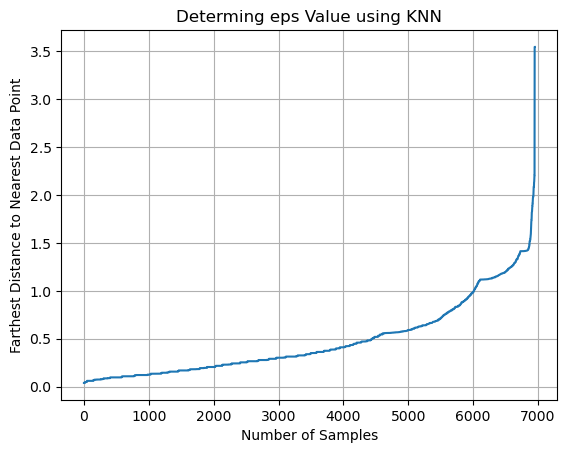

In [66]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=36)
nn.fit(df_for_clustering_modYearDrop)

distances, indices = nn.kneighbors()
sorted_distances = np.sort(distances, axis=0)

# chose 35th column because it has the farthest distance and eps is about farthest distance
plt.plot(sorted_distances[:,35])
plt.xlabel('Number of Samples')
plt.ylabel('Farthest Distance to Nearest Data Point')
plt.title('Determing eps Value using KNN')
plt.grid(True)
plt.show()

In [69]:
sorted_distances[:,35]

array([0.03932523, 0.03932523, 0.03932523, ..., 3.54635061, 3.54635061,
       3.54635061])

I read that eps value should be chosen based on where you see the elbow in this graph. So, based on this, I choose eps value of 0.5 for DBScan baseline model.

In [70]:
from sklearn.cluster import DBSCAN

# Instantiate
dbscan_model = DBSCAN(eps=0.5, min_samples=9)

# Fit and get labels
cluster_labels = dbscan_model.fit_predict(df_for_clustering_modYearDrop)

In [73]:
# Check cluster labels
result = np.unique(cluster_labels, return_counts=True)
unique_labels = result[0]
count = result[1]
pd.DataFrame({'Cluster Label': unique_labels, 'Count': count})

,Cluster Label,Count
0,-1,394
1,0,149
2,1,262
3,2,25
4,3,123
...,...,...
77,76,86
78,77,7
79,78,9
80,79,9


In [74]:
# Find non-noise points
non_noise = cluster_labels[cluster_labels != -1]
# Get number of clusters
n_cluster = len(np.unique(non_noise))
print("This baseline DBScan model came up with ",n_cluster," clusters")

This baseline DBScan model came up with  81  clusters


In [75]:
# Get silhouette score
silhouette = silhouette_score(df_for_clustering_modYearDrop, cluster_labels)
print(silhouette)

0.21747471296066676


Although I did my best to select best possible value for min_sample and eps for the baseline model, it's silhouette score is note even close to the ideal silhouette score (closer to 1). So, it's time to hypertune the parameters.

## Hypertuning

In [80]:
# Instantiate an empty list of silhouette scores and cluster counts
results = []
eps= [0.1, 0.23, 0.5, 0.75, 1.0, 1.5, 2]
min_samples = [1, 3, 6, 9, 12, 15, 18]
# Iterate over eps and min samples
for e in eps:
    for m in min_samples:
        # Instantiate
        dbscan_model = DBSCAN(eps=e, min_samples=m)

        # Fit
        cluster_labels = dbscan_model.fit_predict(df_for_clustering_modYearDrop)

        # Find non-noise points
        non_noise = cluster_labels[cluster_labels != -1]

        # Get silhouette score and number of clusters
        n_cluster = len(np.unique(non_noise))

        if n_cluster > 1:
            silhouette = silhouette_score(df_for_clustering_modYearDrop, cluster_labels)
        else:
            silhouette = np.NaN
    
        # Append to list
        results.append((e, m, n_cluster, silhouette))
        print(f"Running DBScan for eps = {e} and min_samples = {m}")

Running DBScan for eps = 0.1 and min_samples = 1
Running DBScan for eps = 0.1 and min_samples = 3
Running DBScan for eps = 0.1 and min_samples = 6
Running DBScan for eps = 0.1 and min_samples = 9
Running DBScan for eps = 0.1 and min_samples = 12
Running DBScan for eps = 0.1 and min_samples = 15
Running DBScan for eps = 0.1 and min_samples = 18
Running DBScan for eps = 0.23 and min_samples = 1
Running DBScan for eps = 0.23 and min_samples = 3
Running DBScan for eps = 0.23 and min_samples = 6
Running DBScan for eps = 0.23 and min_samples = 9
Running DBScan for eps = 0.23 and min_samples = 12
Running DBScan for eps = 0.23 and min_samples = 15
Running DBScan for eps = 0.23 and min_samples = 18
Running DBScan for eps = 0.5 and min_samples = 1
Running DBScan for eps = 0.5 and min_samples = 3
Running DBScan for eps = 0.5 and min_samples = 6
Running DBScan for eps = 0.5 and min_samples = 9
Running DBScan for eps = 0.5 and min_samples = 12
Running DBScan for eps = 0.5 and min_samples = 15
Runni

In [81]:
results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'n_clusters', 'silhouette_score'])
results_df

,eps,min_samples,n_clusters,silhouette_score
0,0.10,1,771,0.356869
1,0.10,3,364,0.340101
2,0.10,6,211,0.247728
3,0.10,9,143,0.146889
4,0.10,12,104,0.068482
5,0.10,15,86,0.001944
6,0.10,18,61,-0.124110
7,0.23,1,390,0.216404
8,0.23,3,206,0.262531
9,0.23,6,129,0.257395


So, DBScan is a winner! At epsilon value of 1.5 and min_samples value of 15 I am able to get 2 clusters! And guess what! 2 clusters is what I need to becuase I am trying to determine whether the vehicles are green or not green. And by clustering the vehicle in 2 clusters it has done me a HUGE favor! I had been agonozing over how I will analyze 420 clusters to label as green or not green. AH DBSCAN is such a saviour. I'd say this is because DBScan doesn't just cluster is a circular way it is able to pick up other patherns of clusters too. Something KMeans algorithm can't do. 

In [87]:
from sklearn.cluster import DBSCAN

# Instantiate
dbscan_model = DBSCAN(eps=1.5, min_samples=12)

# Fit and get labels
cluster_labels = dbscan_model.fit_predict(df_for_clustering_modYearDrop)

In [88]:
# Check cluster labels
result = np.unique(cluster_labels, return_counts=True)
unique_labels = result[0]
count = result[1]
pd.DataFrame({'Cluster Label': unique_labels, 'Count': count})

,Cluster Label,Count
0,-1,16
1,0,6906
2,1,29


In [89]:
np.unique(cluster_labels)

array([-1,  0,  1], dtype=int64)

In [92]:
df_after_clustering = df_for_clustering_modYearDrop.copy()
df_after_clustering["DBScan_cluster_lables"] = cluster_labels
df_after_clustering.head()

,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating,Vehicle_Class_COMPACT,Vehicle_Class_FULL-SIZE,Vehicle_Class_MID-SIZE,Vehicle_Class_MINICOMPACT,Vehicle_Class_MINIVAN,Vehicle_Class_PICKUP TRUCK - SMALL,Vehicle_Class_PICKUP TRUCK - STANDARD,Vehicle_Class_SPECIAL PURPOSE VEHICLE,Vehicle_Class_STATION WAGON - MID-SIZE,Vehicle_Class_STATION WAGON - SMALL,Vehicle_Class_SUBCOMPACT,Vehicle_Class_SUV - SMALL,Vehicle_Class_SUV - STANDARD,Vehicle_Class_TWO-SEATER,Vehicle_Class_VAN - PASSENGER,DBScan_cluster_lables
0,-0.990427,-1.026786,0.698072,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.010211,0.072781,0.698072,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,-0.097001,-0.058511,0.698072,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,-0.704531,-0.731380,0.698072,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.010211,0.105604,0.698072,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## Visualizing the clusters
Because I have 18 features, I'll need to perform dimensionality reduction using t-SNE in order to visualize my clusters.

In [95]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=1)
tsne_data = tsne.fit_transform(df_after_clustering.drop(['DBScan_cluster_lables'], axis=1))

tsne_dbscan_df = pd.DataFrame(tsne_data, columns=[f'D{i+1}' for i in range(3)])
tsne_dbscan_df['DBScan_cluster_lables'] = df_after_clustering['DBScan_cluster_lables'].values
tsne_dbscan_df.shape

C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(6951, 4)

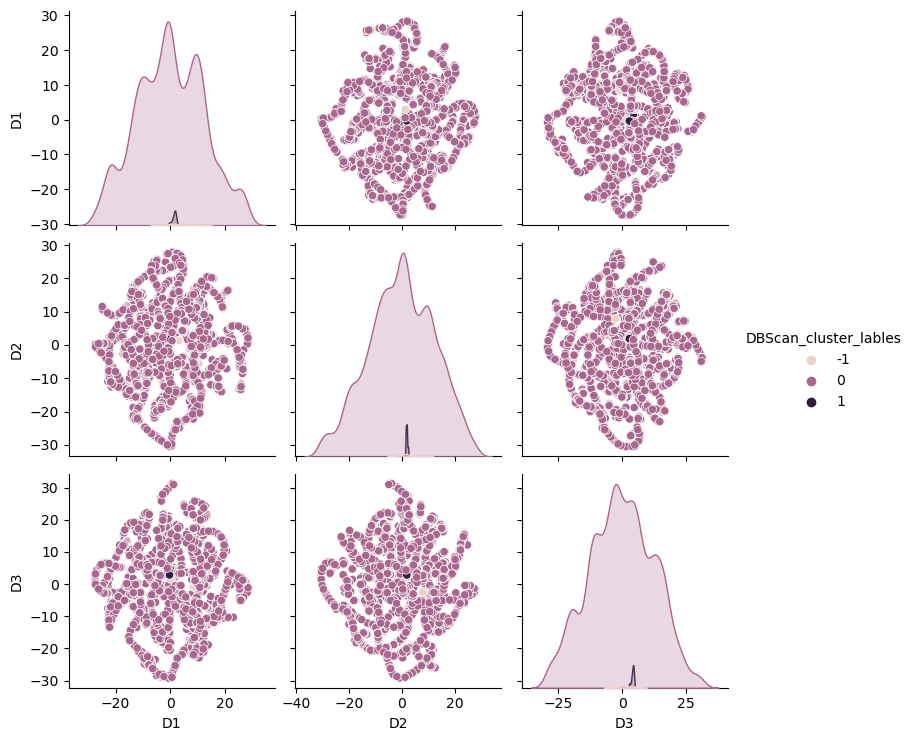

In [96]:
sns.pairplot(tsne_dbscan_df, hue='DBScan_cluster_lables')
plt.show()

In [97]:
# creating an aggregation function to obtain min and max values for specified columns so that it can be used for groupby
agg_functions = {
    'Fuel_Consumption-Comb(L/100 km)': ['min', 'max'],
    'CO2_Emissions(g/km)': ['min', 'max'],
    'Smog_Rating': ['min', 'max']
}

# Grouping by Kmeans labels the specified columns with the aggregation function defined above
grp_by_dbscanLabels_stats = df_after_clustering.groupby('DBScan_cluster_lables').agg(agg_functions).reset_index()

In [100]:
# Since index had same values as kmeans_labels, resetted the index as kmeans_labels to avoid repititon
grp_by_dbscanLabels_stats.set_index('DBScan_cluster_lables', inplace=True)
grp_by_dbscanLabels_stats

Fuel_Consumption-Comb(L/100 km)            \
                                                  min       max   
DBScan_cluster_lables                                             
-1                                           2.726228  5.406509   
 0                                          -2.491385  3.762603   
 1                                           3.012125  4.334396   

                      CO2_Emissions(g/km)           Smog_Rating            
                                      min       max         min       max  
DBScan_cluster_lables                                                      
-1                               1.008233  5.800374    -2.09703  0.139051  
 0                              -2.635107  3.584829    -2.09703  1.816113  
 1                               3.273012  4.667985    -2.09703 -2.097030

In [102]:
agg_functions = {
    'Fuel_Consumption-Comb(L/100 km)': 'median',
    'CO2_Emissions(g/km)': 'median',
    'Smog_Rating': 'median'
}
grp_by_dbscanLabels_median = df_after_clustering.groupby('DBScan_cluster_lables').agg(agg_functions).reset_index()

In [103]:
# Since index had same values as kmeans_labels, resetted the index as kmeans_labels to avoid repititon
grp_by_dbscanLabels_median.set_index('DBScan_cluster_lables', inplace=True)
grp_by_dbscanLabels_median

,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating
DBScan_cluster_lables,,,
-1,3.172942,3.125309,-2.097030
0,-0.132738,-0.091334,0.139051
1,4.012763,4.274110,-2.097030
